In [1]:
import numpy
import pathlib2
import slim_scripts
import subprocess
import matplotlib.pyplot as plt
import seaborn
import pandas
import tqdm

metaRNG = numpy.random.default_rng (4714)

In [2]:
# this is the binary file called to run the slim script
SLIM_BINARY = 'slim'

# and this can reuse simulated stuff
REUSE_SIMULATION_IF_EXISTS = True

In [3]:
# some functions to compute statistics
def getSFS (geno):
    (S, n) = geno.shape
    # number of derived alleles at each site
    numDerivedAlleles = numpy.sum (geno, axis=1)
    # get a histogram and set range and bins such that it is compatible with integers for allele counts
    (histY, histX) = numpy.histogram (numDerivedAlleles, range=(-0.5, n + 0.5), bins=(n+1))
    # no non-segregating sites
    assert (histY[0] == 0)
    return histY


def getWattersonTheta (S, n, sequenceLength):
    harm = numpy.sum (1/numpy.arange(1,n))
    return (S / harm) / sequenceLength


def getPi (geno, sequenceLength):
    (S, n) = geno.shape
    sfs = getSFS (geno)
    assert (len(sfs) == n+1)
    # iterate through seg-sites entries in SFS
    diffs = 0
    for i in numpy.arange(1,n):
        # each derived allele at count i produces i * (n-i) pairwise differences
        diffs += sfs[i] * i * (n-i)
    return (diffs / (n*(n-1)*0.5)) / sequenceLength

def getSfsErrors (reducedSFS):
    numSegSites = numpy.sum (reducedSFS)
    normSFS = reducedSFS / numpy.sum(reducedSFS)
    # these are the means of the frequency estimators using indicators
    means = normSFS
    # get the variances
    meanXSquared = means
    variances = meanXSquared - means*means
    sds = numpy.sqrt (variances)/ numpy.sqrt(numSegSites)
    # scale it back up to counts
    return numSegSites * sds
    

In [4]:
# popgen parameters
mutRate = 1.25 * 1e-8
recoRate = 1.25 * 1e-8
sequenceLength = int(5e6)
sampleSize = 100

# slim param
scalingFactor = 5

In [5]:
# scenarios
theScenarios = {}

# constant 5000
numReplicates = 20
constantDiploidNe = 5000
scripts = []
for r in numpy.arange(numReplicates):
    thisSkript = slim_scripts.singlePopulationBGPiecewise (metaRNG.integers (9999999999), scalingFactor, mutRate, recoRate, sequenceLength, [constantDiploidNe], [], sampleSize)
    scripts.append (thisSkript)
# add them all into the list
theScenarios[f'constant_{constantDiploidNe}'] = scripts

# constant 2500
numReplicates = 20
constantDiploidNe = 3750
scripts = []
for r in numpy.arange(numReplicates):
    thisSkript = slim_scripts.singlePopulationBGPiecewise (metaRNG.integers (9999999999), scalingFactor, mutRate, recoRate, sequenceLength, [constantDiploidNe], [], sampleSize)
    scripts.append (thisSkript)
# add them all into the list
theScenarios[f'constant_{constantDiploidNe}'] = scripts

# recent growth
numReplicates = 20
diploidNes = numpy.array([2500, 3500, 7500, 15000]) * 1.45
changeTimes = numpy.array([120, 80, 40]) * 1.5
scripts = []
for r in numpy.arange(numReplicates):
    thisSkript = constantSkript = slim_scripts.singlePopulationBGPiecewise (metaRNG.integers (9999999999), scalingFactor, mutRate, recoRate, sequenceLength,
                                                                                 diploidNes, changeTimes, sampleSize)
    scripts.append (thisSkript)
# add them all into the list
theScenarios[f'growth_{int(diploidNes[-1])}'] = scripts

# background selection
numReplicates = 20
constantDiploidNe = 5000
delMutRate = mutRate * 0.2
delMutSelCoeff = "0.001"
# delMutRate = mutRate
# delMutSelCoeff = "0"
scripts = []
for r in numpy.arange(numReplicates):
    thisSkript = constantSkript = slim_scripts.singlePopulationBGPiecewise (metaRNG.integers (9999999999), scalingFactor, mutRate, recoRate, sequenceLength,
                                                                                 [constantDiploidNe], [], sampleSize, delMutRate=delMutRate, delMutSelCoeff=-float(delMutSelCoeff))
    scripts.append (thisSkript)
# add them all into the list
theScenarios[f'background_{constantDiploidNe}_m{delMutSelCoeff}'] = scripts


In [6]:
# run all the scripts
outputFiles = {}
for (thisScenario, thisSlimScripts) in theScenarios.items():
    print (f"===== {thisScenario}")
    outputFiles[thisScenario] = []

    # go through replicates in this scenario
    for (rIdx, thisReplicateScript) in tqdm.tqdm(enumerate(thisSlimScripts)):

        # make a subdirectory, name is the scenario name
        subDir = pathlib2.Path (thisScenario)
        # subDir.mkdir (parents=False, exist_ok=False)
        subDir.mkdir (parents=False, exist_ok=True)

        # get the paths for script and output file
        # basename is this scenario
        slimScriptPath = pathlib2.Path (subDir, thisScenario + f"_{rIdx}.slim")
        slimOutputPath = pathlib2.Path (subDir, thisScenario + f"_{rIdx}.out")
        outputFiles[thisScenario].append(slimOutputPath)

        # only re-simulate if needed
        if (REUSE_SIMULATION_IF_EXISTS and slimOutputPath.exists()):
            # print (f"+++ {rIdx}: Ouput exits, reuse.")
            continue
        else:
            # print (f"+++ {rIdx}: Simulate new output.")

            # write the script
            ofs = open (slimScriptPath, 'w')
            ofs.write (thisReplicateScript)
            ofs.close()

            # run the script
            slimCmd = f"{SLIM_BINARY} {str(slimScriptPath)} >{str(slimOutputPath)}"
            result = subprocess.run (slimCmd, shell=True, capture_output=True, text=True)
            # print (result.stderr)
            assert (result.returncode == 0)


===== constant_5000


20it [00:00, 3806.60it/s]


===== constant_3750


20it [00:00, 1555.23it/s]


===== growth_21750


20it [00:00, 3999.91it/s]


===== background_5000_m0.001


20it [00:00, 3116.24it/s]


In [7]:
# assert (False)

In [8]:
# load the genotype from the files
genotypes = {}
for (thisScenario, theseFiles) in outputFiles.items():
    genotypes[thisScenario] = []
    for thisFile in theseFiles:

        # read the output from the slim simulation
        ifs = open (thisFile)
        slimLines = ifs.readlines()
        ifs.close()

        # get the genotypes
        (geno, positions) = slim_scripts.getGenoFromSlimOutput (slimLines, sequenceLength, sampleSize)

        # and store it
        genotypes[thisScenario].append ((geno, positions))


In [9]:
# compute diversity statistics
allThetas = {}
allPis = {}
for (thisScenario, theseGenos) in genotypes.items():
    print (f"===== {thisScenario}")

    # cumulatively
    allS = 0
    pis = []
    for (rIdx, v) in enumerate(theseGenos):
        (rGeno, rPositions) = v
        thisS = rGeno.shape[0]
        reducedGeno = rGeno[numpy.sum(rGeno,axis=1)<rGeno.shape[1],:]
        n = reducedGeno.shape[1]
        allS += thisS
        thisPi = getPi (rGeno, sequenceLength)
        pis.append (thisPi)

    allThetas[thisScenario] = getWattersonTheta (allS, n, sequenceLength*len(theseGenos))
    print (f"Watterson: {allThetas[thisScenario]:.6f}")
    allPis[thisScenario] = numpy.mean(pis)
    print (f"pi: {allPis[thisScenario]:.6f}")


===== constant_5000
Watterson: 0.000248
pi: 0.000246
===== constant_3750
Watterson: 0.000187
pi: 0.000185
===== growth_21750
Watterson: 0.000212
pi: 0.000183
===== background_5000_m0.001
Watterson: 0.000208
pi: 0.000186


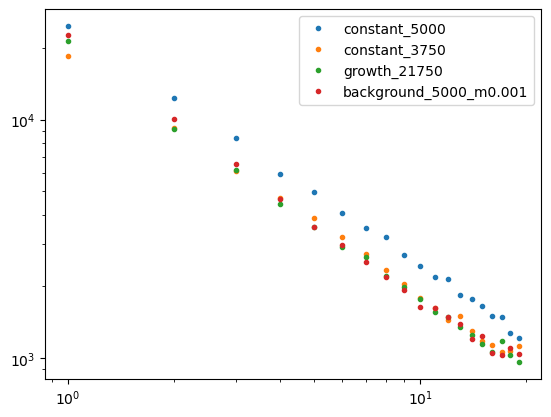

In [10]:
# plot some SFSs
theLegend = []
for (thisScenario, theseGenos) in genotypes.items():
    thisSFS = None
    for (rIdx, v) in enumerate(theseGenos):
        (thisGeno, thisPositions) = v

        # get SFS from genotype matrix
        reducedGeno = thisGeno[:,:20]
        # reducedGeno = thisGeno
        reducedGeno = reducedGeno[numpy.sum(reducedGeno,axis=1)>0,:]
        if (thisSFS is None):
            thisSFS = getSFS (reducedGeno)
        else:
            thisSFS += getSFS (reducedGeno)

    n = len(thisSFS)-1
    xs = numpy.arange(1, n)
    ys = thisSFS[1:-1]
    # plt.bar (xs, ys)
    plt.plot (xs, ys, '.')
    plt.yscale ('log')
    plt.xscale ('log')

    theLegend.append (thisScenario)

plt.legend (theLegend)

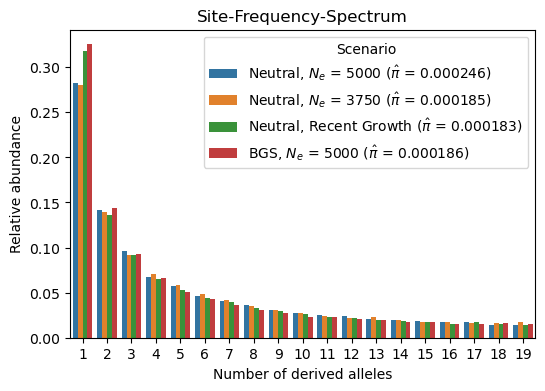

In [11]:
# try some seaborn shenanigans
plt.figure (figsize=(6,4))
legendText = {
    'constant_5000' : r'Neutral, $N_e$ = 5000 ($\hat{\pi}$ = ' + f"{allPis['constant_5000']:.6f}" + ')',
    'constant_3750' : r'Neutral, $N_e$ = 3750 ($\hat{\pi}$ = ' + f"{allPis['constant_3750']:.6f}" + ')',
    f'growth_{int(diploidNes[-1])}' : r'Neutral, Recent Growth ($\hat{\pi}$ = ' + f"{allPis[f'growth_{int(diploidNes[-1])}']:.6f}" + ')',
    'background_5000_m0.001' : r'BGS, $N_e$ = 5000 ($\hat{\pi}$ = ' + f"{allPis['background_5000_m0.001']:.6f}" + ')',
}
# first make up a dataframe
frameSamplesSizes = []
frameCounts = []
frameLabels = []
# frameError = []
for (thisScenario, thisLegend) in legendText.items():
    theseGenos = genotypes[thisScenario]
    thisSFS = None
    for (rIdx, v) in enumerate(theseGenos):
        (thisGeno, thisPositions) = v

        # get SFS from genotype matrix
        reducedGeno = thisGeno[:,:20]
        # reducedGeno = thisGeno
        reducedGeno = reducedGeno[numpy.sum(reducedGeno,axis=1)>0,:]
        # reducedGeno = reducedGeno[::5,:]
        if (thisSFS is None):
            thisSFS = getSFS (reducedGeno)
        else:
            thisSFS += getSFS (reducedGeno)

    n = len(thisSFS)-1
        
    frameSamplesSizes.extend (numpy.arange(1,n))
    frameCounts.extend (thisSFS[1:-1]/numpy.sum(thisSFS[1:-1]))
    frameLabels.extend (numpy.repeat (thisLegend, n-1))
    # frameError.extend (1.96 * getSfsErrors(thisSFS[1:-1]))

assert (len(frameSamplesSizes) == len(frameCounts))
assert (len(frameSamplesSizes) == len(frameLabels))

# put it into a frame
sfsFrame = pandas.DataFrame ({
    "Number of derived alleles" : frameSamplesSizes,
    "Relative abundance" : frameCounts,
    "Scenario" : frameLabels,
})

seaAx = seaborn.barplot (sfsFrame, x="Number of derived alleles", y="Relative abundance", hue="Scenario")
seaAx.set_title ('Site-Frequency-Spectrum')

# # some error bars
# x_coords = [p.get_x() + 0.5 * p.get_width() for p in seaAx.patches]
# y_coords = [p.get_height() for p in seaAx.patches]
# seaAx.errorbar (x=x_coords[:-3], y=y_coords[:-3], yerr=frameError, fmt="none", c="k")

# seaAx.set_yscale ('log')
# seaAx.set_ylim (300,20000)
# seaAx.set_ylim (0,13200)

plt.savefig ('figure_4_sfs_background.pdf')